#### GA Insert Analysis

This code varies the masked section of pLac to see how it relates to the upper and lower bounds of the promoter's expression.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import random
import time
from tqdm import tqdm

from GA_params_test import GeneticAlgorithm

In [2]:
# Initialize the parameters
cnn_model_path = '../../Models/CNN_6_1_2.keras'
target_expressions = [0, 1]
precision = 0.001
verbose = 0

# Set the seed
seed = 0
random.seed(seed)

# pLac parameters
pLac_up = 'AATACTAGAGGTCTTCCGAC'
pLac_change = 'TTTACACTTTATGCTTCCGGCTCGTATGTT'
pLac_down = 'GTGTGGGCGGGAAGACAACTAGGGG'

# Exhaustiveness parameters
lineages = 5
tests = 10
sequences_per_test = 10
mask_counts = np.linspace(1, len(pLac_change), tests, dtype=int)

In [3]:
def replace_sequence(seq, n):
    indices_to_replace = random.sample(range(len(seq)), n)
    return ''.join([seq[i] if i not in indices_to_replace else 'N' for i in range(len(seq))])

In [5]:
data = {
    'mask_counts': [],
    'target_expression': [],
    'best_prediction': [],
}

total_iterations = len(mask_counts) * sequences_per_test * len(target_expressions)
progress_bar = tqdm(total=total_iterations, desc="Processing Masked Sequences", position=0)

start_time = time.time()

for mask_count in mask_counts:
    for i in range(sequences_per_test):
        masked_sequence = pLac_up + replace_sequence(pLac_change, mask_count) + pLac_down
        for target_expression in target_expressions:
            ga = GeneticAlgorithm(
                cnn_model_path=cnn_model_path,
                masked_sequence=masked_sequence,
                target_expression=target_expression,
                precision=precision,
                verbose=verbose,
                seed=0,
            )
            best_sequences, best_predictions = ga.run(lineages)

            data['mask_counts'].extend([mask_count] * len(best_predictions))
            data['target_expression'].extend([target_expression] * len(best_predictions))
            data['best_prediction'].extend(best_predictions)

            # Update progress bar
            progress_bar.update(1)
            elapsed_time = time.time() - start_time
            progress_bar.set_postfix({
                "Elapsed": f"{elapsed_time:.2f}s",
                "ETA": f"{(elapsed_time / progress_bar.n) * (total_iterations - progress_bar.n):.2f}s"
            })

# Close progress bar
progress_bar.close()

df = pd.DataFrame(data)
df.head()

Processing Masked Sequences: 100%|██████████| 200/200 [23:39<00:00,  7.10s/it, Elapsed=1419.37s, ETA=0.00s]  


,mask_counts,target_expression,best_prediction
0,1,0,0.312193
1,1,0,0.312193
2,1,0,0.312193
3,1,0,0.312193
4,1,0,0.312193


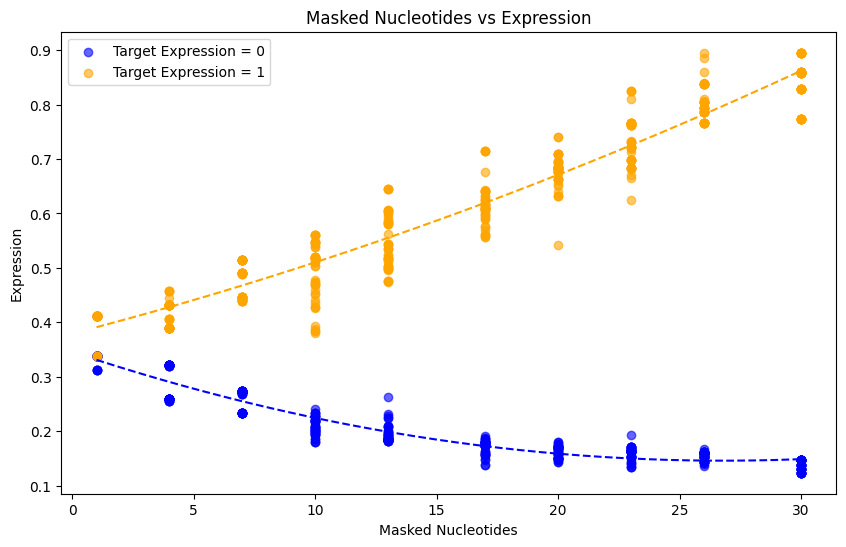

In [6]:
# Filter the data for the two target expressions
data_target_0 = df[df['target_expression'] == 0]
data_target_1 = df[df['target_expression'] == 1]

# Polynomial fit for target_expression = 0
coeffs_0 = np.polyfit(data_target_0['mask_counts'], data_target_0['best_prediction'], deg=2)
poly_fit_0 = np.poly1d(coeffs_0)
x_0 = np.linspace(data_target_0['mask_counts'].min(), data_target_0['mask_counts'].max(), 500)
y_0 = poly_fit_0(x_0)

# Polynomial fit for target_expression = 1
coeffs_1 = np.polyfit(data_target_1['mask_counts'], data_target_1['best_prediction'], deg=2)
poly_fit_1 = np.poly1d(coeffs_1)
x_1 = np.linspace(data_target_1['mask_counts'].min(), data_target_1['mask_counts'].max(), 500)
y_1 = poly_fit_1(x_1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(data_target_0['mask_counts'], data_target_0['best_prediction'], color='blue', alpha=0.6, label='Target Expression = 0')
plt.scatter(data_target_1['mask_counts'], data_target_1['best_prediction'], color='orange', alpha=0.6, label='Target Expression = 1')
plt.plot(x_0, y_0, color='blue', linestyle='--', label=None)
plt.plot(x_1, y_1, color='orange', linestyle='--', label=None)

# Add labels, legend, and title
plt.xlabel('Masked Nucleotides')
plt.ylabel('Expression')
plt.title('Masked Nucleotides vs Expression')
plt.legend()

# Show the plot
plt.show()